<a href="https://www.kaggle.com/code/markkiarie/v2-dms?scriptVersionId=219474042" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 137ms/step - accuracy: 0.9581 - loss: 0.1468 - val_accuracy: 0.9907 - val_loss: 0.0245
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9934 - loss: 0.0220 - val_accuracy: 0.9875 - val_loss: 0.0410
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9938 - loss: 0.0203 - val_accuracy: 0.9907 - val_loss: 0.0335
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9969 - loss: 0.0125 - val_accuracy: 0.9929 - val_loss: 0.0220
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9937 - loss: 0.0180 - val_accuracy: 0.9968 - val_loss: 0.0112
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9964 - loss: 0.0141 - val_accuracy: 0.9968 - val_loss: 0.0136
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9935 - loss: 0.0190 - val_accuracy: 0.9971 - val_loss: 0.0071
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.9952 - loss: 0.0164 - val

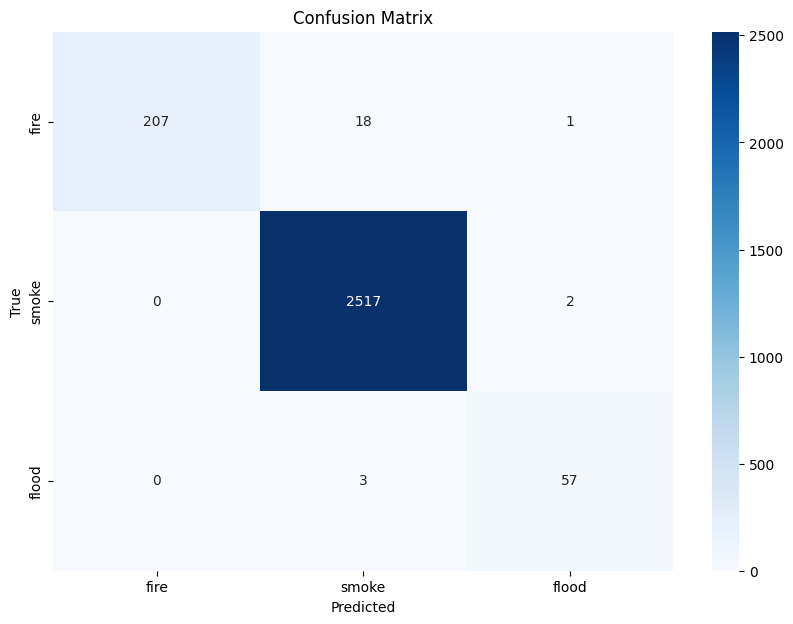


Classification Report:
              precision    recall  f1-score   support

        fire       1.00      0.92      0.96       226
       smoke       0.99      1.00      1.00      2519
       flood       0.95      0.95      0.95        60

    accuracy                           0.99      2805
   macro avg       0.98      0.96      0.97      2805
weighted avg       0.99      0.99      0.99      2805



In [1]:
# Importing Essential Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Dataset Paths
fire_paths = {
    'train_smoke': '/kaggle/input/forest-fire/train-smoke',
    'train_fire': '/kaggle/input/forest-fire/train_fire',
    'test_big': '/kaggle/input/forest-fire/test_big',
    'test_small': '/kaggle/input/forest-fire/test_small'
}
flood_path = '/kaggle/input/flood-area-segmentation/Image'

# Global Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
LABEL_DICT = {'fire': 0, 'smoke': 1, 'flood': 2}

# Utility Function to Load Images
def load_images_from_directory(directory, label, image_size):
    """Loads and preprocesses images from a given directory."""
    images, labels = [], []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img = tf.keras.utils.img_to_array(img) / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load Fire and Smoke Images
fire_images, fire_labels = load_images_from_directory(fire_paths['train_fire'], 'fire', IMAGE_SIZE)
smoke_images, smoke_labels = load_images_from_directory(fire_paths['train_smoke'], 'smoke', IMAGE_SIZE)

# Merge Fire and Smoke Data
fire_smoke_images = np.concatenate((fire_images, smoke_images), axis=0)
fire_smoke_labels = np.concatenate((fire_labels, smoke_labels), axis=0)

# Encode Labels for Fire and Smoke
fire_smoke_labels_encoded = np.array([LABEL_DICT[label] for label in fire_smoke_labels])

# Load Flood Images
flood_images, flood_labels = load_images_from_directory(flood_path, 'flood', IMAGE_SIZE)
flood_labels_encoded = np.array([LABEL_DICT['flood']] * len(flood_labels))

# Combine All Data
all_images = np.concatenate((fire_smoke_images, flood_images), axis=0)
all_labels_encoded = np.concatenate((fire_smoke_labels_encoded, flood_labels_encoded), axis=0)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels_encoded, test_size=0.2, random_state=42)

# Data Augmentation
data_augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
data_augmentor.fit(X_train)

# Model Definition
def create_model(input_shape=(128, 128, 3), num_classes=3):
    """Defines and returns a CNN model based on MobileNetV2."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

# Instantiate and Compile Model
model = create_model(input_shape=(128, 128, 3), num_classes=len(LABEL_DICT))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(
    data_augmentor.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=10
)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Visualizing Predictions
def visualize_predictions(model, X_test, y_test, label_dict):
    """Displays a confusion matrix and classification report."""
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_dict.keys()))

# Run Visualization
visualize_predictions(model, X_test, y_test, LABEL_DICT)


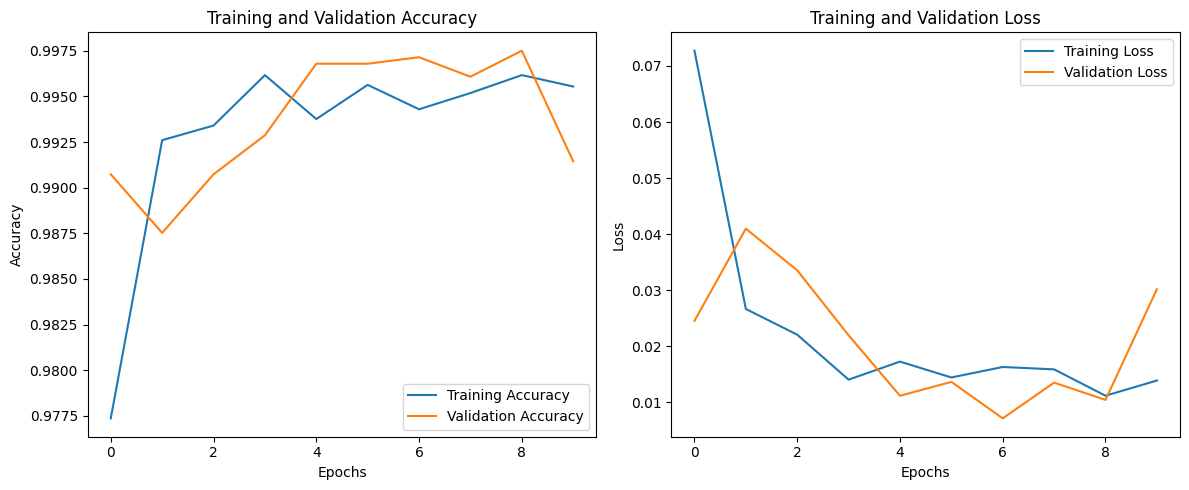

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


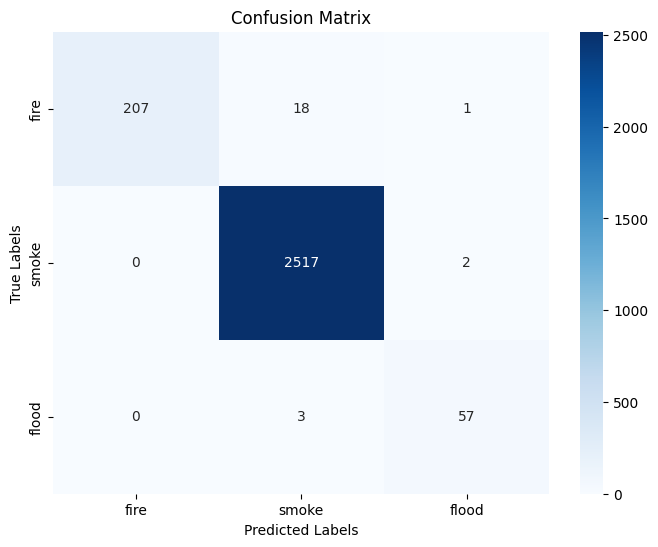

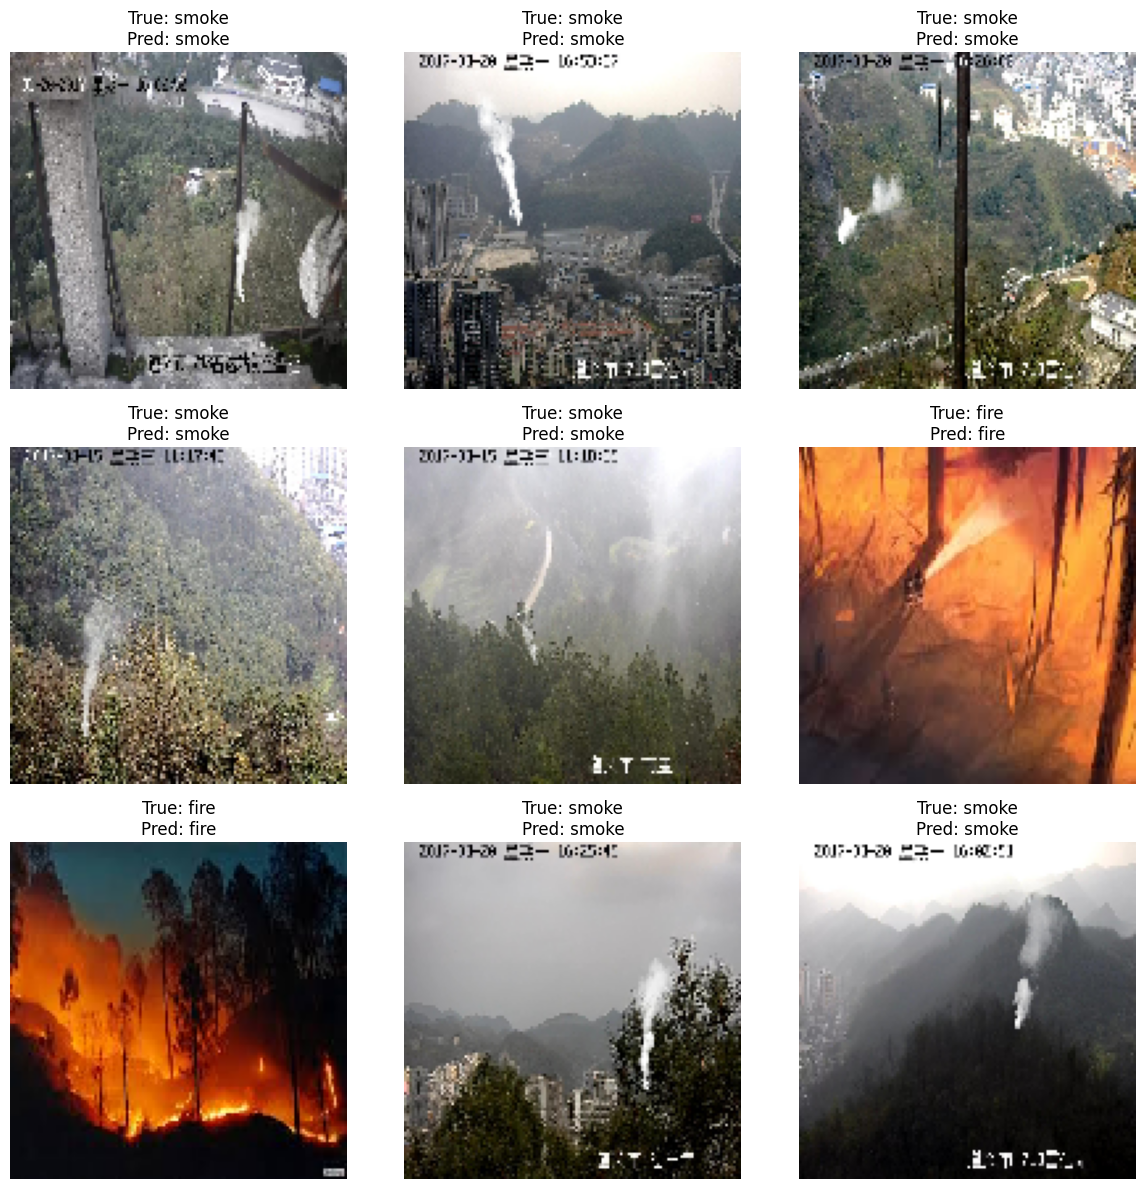

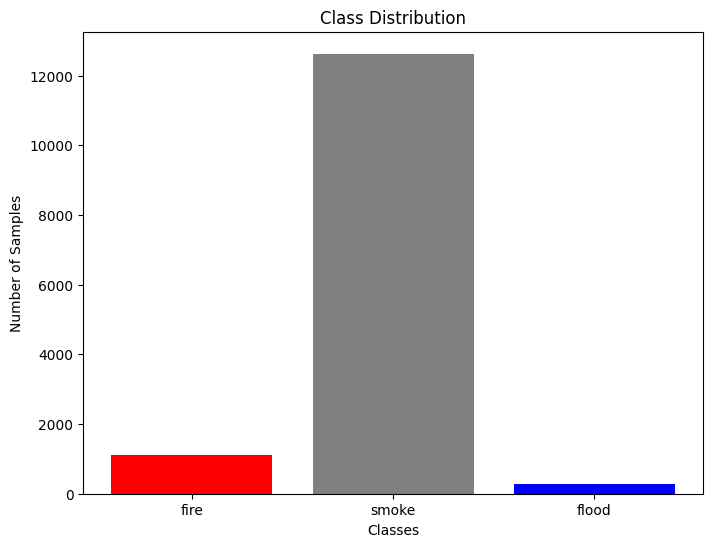

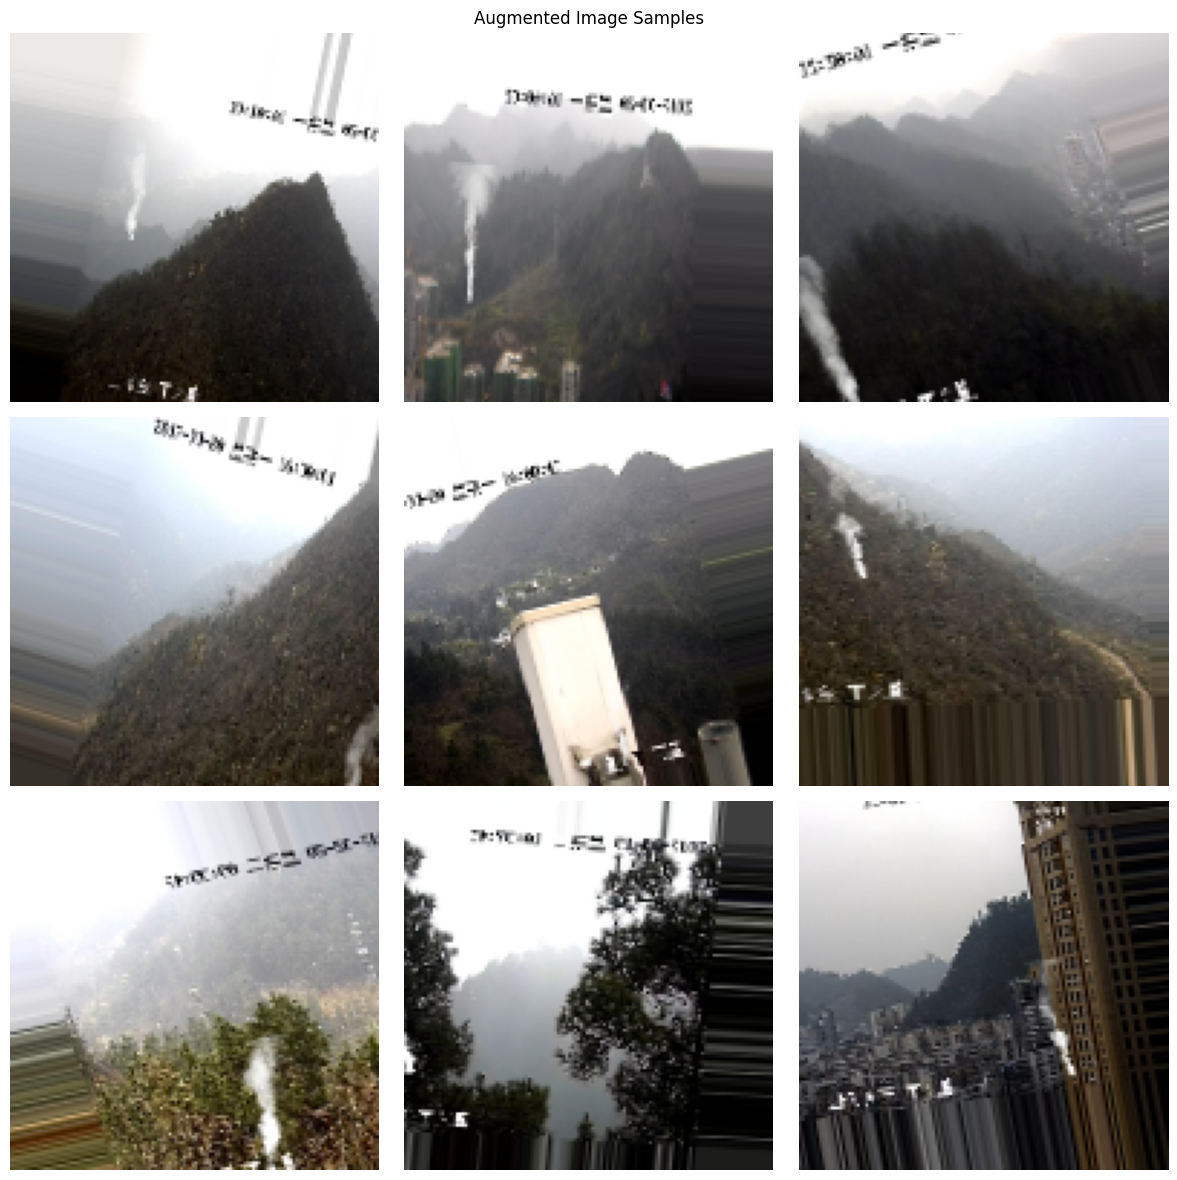

In [2]:
# Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_DICT.keys(), yticklabels=LABEL_DICT.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Sample Predictions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()
for i in range(9):
    idx = np.random.randint(0, len(X_test))
    axes[i].imshow(X_test[idx])
    axes[i].set_title(f"True: {list(LABEL_DICT.keys())[y_test[idx]]}\nPred: {list(LABEL_DICT.keys())[y_pred_classes[idx]]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Class Distribution
labels, counts = np.unique(all_labels_encoded, return_counts=True)
label_names = [key for key, val in LABEL_DICT.items() if val in labels]

plt.figure(figsize=(8, 6))
plt.bar(label_names, counts, color=['red', 'gray', 'blue'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

# Augmentation Examples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.ravel()):
    img = X_train[i]
    augmented_img = data_augmentor.random_transform(img)
    ax.imshow(augmented_img)
    ax.axis('off')
plt.suptitle('Augmented Image Samples')
plt.tight_layout()
plt.show()
